# **영화 리뷰 긍/부정 학습**

👉 데이터 가져오기

In [1]:
!pip install konlpy
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install nltk
!pip install keras
!pip install konlpy
!pip install sklearn
!pip install matplotlib

In [2]:
import pandas as pd
import numpy as np
import urllib.request

In [3]:
# git에서 txt파일 가져오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")


# 파일을 읽어와 Corpus를 만드는 함수
def read_data(filename, encoding):
    data = []
    with open(filename, encoding=encoding) as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]
    return data

train_data = read_data("ratings_train.txt", 'utf-8')
test_data = read_data("ratings_test.txt", 'utf-8')    

In [4]:
train_data[:5]
#test_data[:5]

[['9976970', '아 더빙.. 진짜 짜증나네요 목소리', '0'],
 ['3819312', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '1'],
 ['10265843', '너무재밓었다그래서보는것을추천한다', '0'],
 ['9045019', '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정', '0'],
 ['6483659',
  '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다',
  '1']]

In [5]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트 리뷰 개수 :',len(test_data)) # 테스트 리뷰 개수 출력

# 학습용 데이터 150,000건, 테스트용 데이터 50,000건

훈련용 리뷰 개수 : 150000
테스트 리뷰 개수 : 50000


👉🏻 토큰화

In [6]:
import konlpy
from konlpy.tag import Okt
okt=Okt()

import json
import os
from pprint import pprint

In [7]:
# 토큰화 : 문자열에서 단어로 분리(하나의 문장을 토큰화 한 후 텍스트와 품사태깅을 '/'구분자로 묶어준다.)
def tokenize(doc):
    # norm은 문장을 정규화, stem은 각 단어에서 어간을 추출(기본 값은 둘다 False)
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

train_docs=[] # 훈련 데이터
test_docs=[] # 테스트 데이터
train_docs0=[]
test_docs0=[]

for row in train_data:
    train_docs0 = [tokenize(row[1]),row[2]] 
    #리스트 안에 한문장에 대해서 위에서 만든 tokenizing함수를 통해서 [[토큰화텍스트],긍/부정 여부]를 리스트의 각 문장 별로 요소로 넣는다.
    train_docs.append(train_docs0)
    
for row in test_data:
    test_docs0 = [tokenize(row[1]),row[2]] 
    test_docs.append(test_docs0)

In [8]:
train_docs[:1]

tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))
tokens[0]

2159921


'아/Exclamation'

👉🏻 nltk(자연어 처리)

In [9]:
import nltk

In [10]:
# nltk 전처리
text = nltk.Text(tokens, name='NMSC')
# 전체 토큰 수
print(len(text.tokens))

# 중복을 제외한 토큰의 개수
print(len(set(text.tokens)))            

# 출현 빈도가 높은 상위 토큰 10개
pprint(text.vocab().most_common(10))

2159921
49895
[('./Punctuation', 67778),
 ('영화/Noun', 50818),
 ('하다/Verb', 41209),
 ('이/Josa', 38540),
 ('보다/Verb', 38538),
 ('의/Josa', 30188),
 ('../Punctuation', 29055),
 ('가/Josa', 26627),
 ('에/Josa', 26468),
 ('을/Josa', 23118)]


👉🏻 CountVectorization(데이터 벡터화)

In [11]:
# 자주 사용되는 토큰을 데이터 벡터화하는데 처리 시간이 오래 걸리므로 most_common의 매개변수를 1000건 정도로 적게 설정하였다.
selected_words = [f[0] for f in text.vocab().most_common(1000)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]


print(train_docs[:5])
train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _, c in train_docs]
test_y = [c for _, c in test_docs]

[[['아/Exclamation', '더빙/Noun', '../Punctuation', '진짜/Noun', '짜증나다/Adjective', '목소리/Noun'], '0'], [['흠/Noun', '.../Punctuation', '포스터/Noun', '보고/Noun', '초딩/Noun', '영화/Noun', '줄/Noun', '..../Punctuation', '오버/Noun', '연기/Noun', '조차/Josa', '가볍다/Adjective', '않다/Verb'], '1'], [['너/Modifier', '무재/Noun', '밓었/Noun', '다그/Noun', '래서/Noun', '보다/Verb', '추천/Noun', '한/Josa', '다/Adverb'], '0'], [['교도소/Noun', '이야기/Noun', '구먼/Noun', '../Punctuation', '솔직하다/Adjective', '재미/Noun', '는/Josa', '없다/Adjective', '../Punctuation', '평점/Noun', '조정/Noun'], '0'], [['사이/Modifier', '몬페/Noun', '그/Determiner', '의/Noun', '익살스럽다/Adjective', '연기/Noun', '가/Josa', '돋보이다/Verb', '영화/Noun', '!/Punctuation', '스파이더맨/Noun', '에서/Josa', '늙다/Verb', '보이다/Verb', '하다/Verb', '커스틴/Noun', '던스트/Noun', '가/Josa', '너무나도/Adverb', '이쁘다/Adjective', '보이다/Verb'], '1']]


In [12]:
# float로 형 변환
x_train = np.asarray(train_x).astype('float32')
y_train = np.asarray(train_y).astype('float32')

x_test = np.asarray(test_x).astype('float32')
y_test = np.asarray(test_y).astype('float32')

👉🏻 모델 정의

In [13]:
import tensorflow as tf

from tensorflow.keras import models, layers, optimizers, losses, metrics

In [14]:
model = models.Sequential()
model.add(layers.Dense(64, 'relu', 10000))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# RMSProp optimizer를 통해서 경사하강법을 진행
# binary_crossentropy 손실 함수
# 모델 생성
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

# 배치 사이즈(batch_size)를 500으로 학습 횟수(epochs)를 10번으로 진행.
model.fit(x_train, y_train, epochs=10, batch_size=500)
results = model.evaluate(x_test, y_test)

#예측 결과
results #82%의 정확도를 가진다.

Epoch 1/10
300/300 [==============================] - 6s 13ms/step - loss: 0.4856 - binary_accuracy: 0.7723
Epoch 2/10
300/300 [==============================] - 2s 8ms/step - loss: 0.3797 - binary_accuracy: 0.8255
Epoch 3/10
300/300 [==============================] - 1s 3ms/step - loss: 0.3664 - binary_accuracy: 0.8321
Epoch 4/10
300/300 [==============================] - 1s 3ms/step - loss: 0.3508 - binary_accuracy: 0.8412
Epoch 5/10
300/300 [==============================] - 1s 3ms/step - loss: 0.3388 - binary_accuracy: 0.8480
Epoch 6/10
300/300 [==============================] - 1s 3ms/step - loss: 0.3255 - binary_accuracy: 0.8561
Epoch 7/10
300/300 [==============================] - 1s 3ms/step - loss: 0.3158 - binary_accuracy: 0.8622
Epoch 8/10
300/300 [==============================] - 1s 3ms/step - loss: 0.3049 - binary_accuracy: 0.8677
Epoch 9/10
300/300 [==============================] - 1s 3ms/step - loss: 0.2942 - binary_accuracy: 0.8734
Epoch 10/10
1563/1563 [=============

[0.3948001563549042, 0.8302199840545654]

In [15]:
def predict_pos_text(text):
    token=tokenize(text) #okt.pos로 토큰화한 단어를 정리
    tf=term_frequency(token)#토큰화된 단어를 이용해서 가장 많이 등장하는 단어와의 빈도수 체크

    data=np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    #data는 그럼 입력받는 text가 한 문장만 받기 때문에 가장 바깥 리스트의 요소 갯수는 1이 될 것이고
    #마찬가지로 리스트 안 리스트 요소내의 갯수는 10000개가 될 것이다.
    score=float(model.predict(data)) #새로운 데이터를 받으면 결과 예측
    if(score > 0.5):
        print("'{}'는 {:.2f}% 확률로 긍정 리뷰입니다.\n".format(text, score * 100))
    else:
        print("'{}']는 {:.2f}% 확률로 부정 리뷰입니다.\n".format(text, (1 - score) * 100))

In [16]:
predict_pos_text('아 더빙.. 진짜 짜증나네요 목소리')
predict_pos_text('흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나')
predict_pos_text('너무재밓었다그래서보는것을추천한다')
predict_pos_text('교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정')
predict_pos_text('사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다')
predict_pos_text('그냥 그렇다')

'아 더빙.. 진짜 짜증나네요 목소리']는 98.56% 확률로 부정 리뷰입니다.

'흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나'는 68.47% 확률로 긍정 리뷰입니다.

'너무재밓었다그래서보는것을추천한다'는 70.30% 확률로 긍정 리뷰입니다.

'교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정']는 91.04% 확률로 부정 리뷰입니다.

'사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다'는 87.77% 확률로 긍정 리뷰입니다.

'그냥 그렇다']는 90.25% 확률로 부정 리뷰입니다.



# **AUC-ROC Curve**

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score

import matplotlib.pyplot as plt

**ROC-Curve : 머신러닝의 이진 분류 모델의 예측 성능을 판단하는 중요한 평가 지표**

**FPR(허위 양성 비율)이 변할 때 TPR(재현율, 민감도)이 어떻게 변하는지를 나타내는 곡선**

**👉 FPR(False Positive Rate) = FP / (FP + TN) = 1 - TNR(특이성)**

**👉🏻 TPR(True Positive Rate) = TP / (FN + TP)**

In [18]:
lr_clf=LogisticRegression()
lr_clf.fit(x_train, y_train)

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class = lr_clf.predict_proba(x_test)[:, 1]

fprs, tprs, thresholds=roc_curve(y_test, pred_proba_class)
# 반환된 임곗값을 5step으로 추출.
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index=np.arange(1, thresholds.shape[0], 5)

print('샘플 추출을 위한 임곗값 배열의 index : ', thr_index)
print('샘플용 임곗값 : ', np.round(thresholds[thr_index],2))

# 5 step 단위로 추출된 임곗값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR : ', np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPR : ', np.round(tprs[thr_index],3))

/Users/sunghwanpark/opt/anaconda3/envs/pyshpark/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


샘플 추출을 위한 임곗값 배열의 index :  [    1     6    11 ... 12991 12996 13001]
샘플용 임곗값 :  [1. 1. 1. ... 0. 0. 0.]
샘플 임곗값별 FPR :  [0.    0.    0.    ... 0.98  0.988 1.   ]
샘플 임곗값별 TPR :  [0.    0.008 0.011 ... 1.    1.    1.   ]


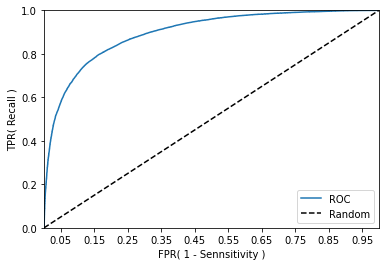

In [19]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환받음.
    fprs, tprs, thresholds=roc_curve(y_test, pred_proba_c1)
    
    # ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label='ROC')
    
    # 가운데 대각선 직선
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    
    # FPR X 축의 Scale을 0.1단위로 변경,  X, Y축 명 설정
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR( 1 - Sennsitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba_class)

👉🏻 AUC(Area Under Curve)

**AUC : ROC 곡선 밑 면적으로 분류의 성능 지표로 1에 가까울수록 좋은 수치**

**FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있는지가 좋은 AUC 수치**

In [20]:
roc_auc=roc_auc_score(y_test, pred_proba_class)

print('AUC : {0:.4f}'.format(roc_auc))

AUC : 0.8967


In [21]:
def get_clf_eval(y_test, pred1=None, pred_proba1=None):
    confusion=confusion_matrix(y_test, pred1)
    
    # ROC-AUC 추가
    roc_auc=roc_auc_score(y_test, pred_proba1)
    print('오차 행렬')
    print(confusion)
    
    # ROC-AUC print 추가
    print('AUC : {0:.4f}'.format(roc_auc))
    
pred = lr_clf.predict(x_test)
get_clf_eval(y_test, pred, pred_proba_class)

오차 행렬
[[20736  4091]
 [ 5083 20090]]
AUC : 0.8967
